In [1]:
import os
import numpy as np
import mne
import sails
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA
#from autoreject import AutoReject
from scipy import signal
import pickle
from scipy.spatial import distance_matrix
from scipy.io import savemat
from scipy.stats import pearsonr
%matplotlib inline

plt.rcParams['figure.figsize'] = [17, 12]
dataset_path = os.path.join('cichy_data', 'subj01', 'raw_data',
                            'MEG2_subj01_sess01_tsss_mc-0.fif')
high_pass = 0.1
low_pass = 124.999

## Load data

In [2]:
# Load data
raw = mne.io.read_raw_fif(dataset_path, preload=True)

Opening raw data file cichy_data/subj01/raw_data/MEG2_subj01_sess01_tsss_mc-0.fif...


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_2062/490537154.py:2: RuntimeWarning: This filename (cichy_data/subj01/raw_data/MEG2_subj01_sess01_tsss_mc-0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


FileNotFoundError: fname does not exist: cichy_data/subj01/raw_data/MEG2_subj01_sess01_tsss_mc-0.fif

In [5]:
raw.load_data()

<Raw | MEG2_subj01_sess01_tsss_mc-0.fif, 323 x 5009000 (5009.0 s), ~12.06 GB, data loaded>

In [20]:
# Pick MEG channels
#raw.pick_types(meg=True, ref_meg=False, stim=True)
raw.info

<Info | 24 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: MEG0111, MEG0112, MEG0113, MEG0121, MEG0122, MEG0123, MEG0131, ...
 chs: 102 MAG, 204 GRAD, 6 MISC, 1 STIM, 1 SYST, 9 CHPI
 custom_ref_applied: False
 description: Vectorview system
 dev_head_t: MEG device -> head transform
 dig: 114 items (3 Cardinal, 5 HPI, 106 Extra)
 events: 1 item (list)
 experimenter: meg (meg)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 60.0
 lowpass: 330.0 Hz
 meas_date: 2014-03-20 18:19:38 UTC
 meas_id: 4 items (dict)
 nchan: 323
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: meg_two
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 7 items (dict)
>

## Filter

In [3]:
# Band pass and notch line noise
raw = raw.filter(l_freq=high_pass, h_freq=low_pass, phase='minimum')
raw = raw.notch_filter(freqs=np.arange(50, 151, 50), phase='minimum')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.10 Hz
- Upper transition bandwidth: 31.25 Hz
- Filter length: 33001 samples (33.001 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



## ICA artefact removal

In [4]:
filt_raw = raw.copy()
filt_raw.filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



<Raw | MEG2_subj01_sess01_tsss_mc-0.fif, 323 x 5009000 (5009.0 s), ~12.06 GB, data loaded>

In [5]:
ica = mne.preprocessing.ICA(n_components=64)
ica.fit(filt_raw)

Fitting ICA to data using 306 channels (please be patient, this may take a while)


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_3010/1568178273.py:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=64)


Selecting by number: 64 components
Fitting ICA took 854.4s.


<ICA | raw data decomposition, fit (fastica): 5009000 samples, 64 components, channels used: "mag"; "grad">

In [6]:
ica_sources = ica.get_sources(raw).get_data()

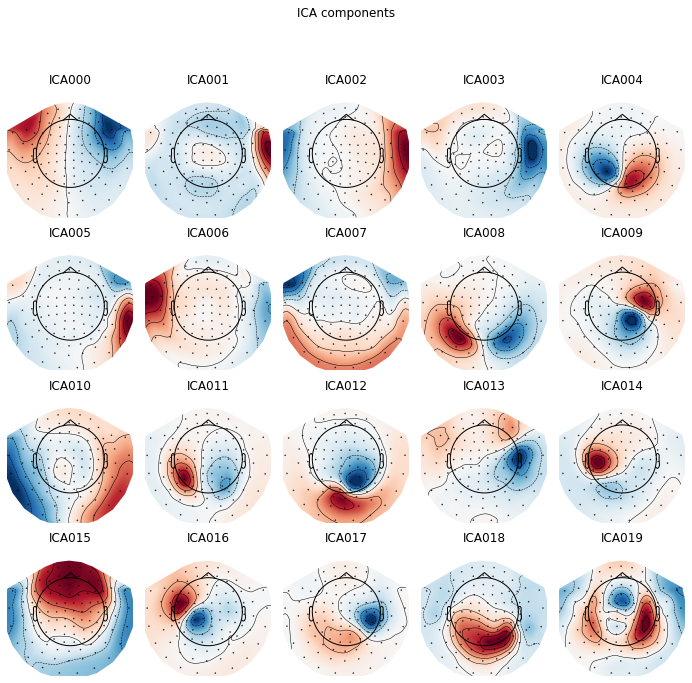

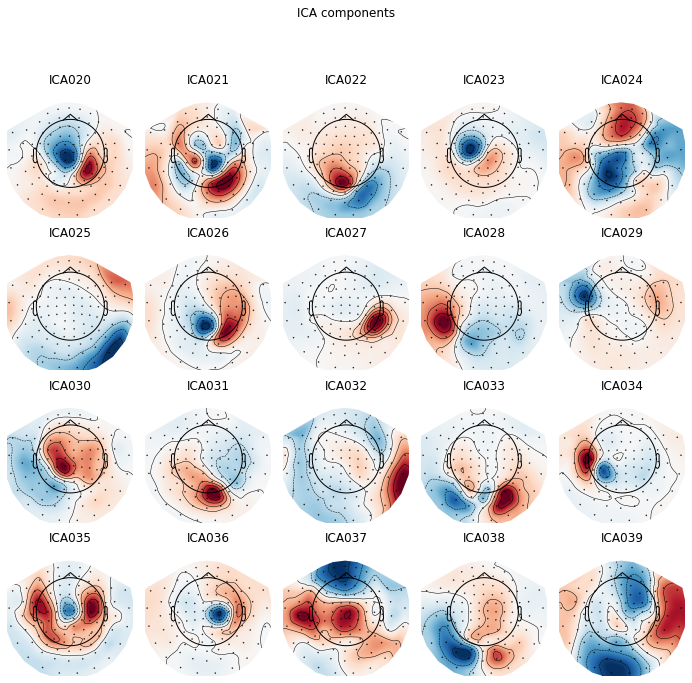

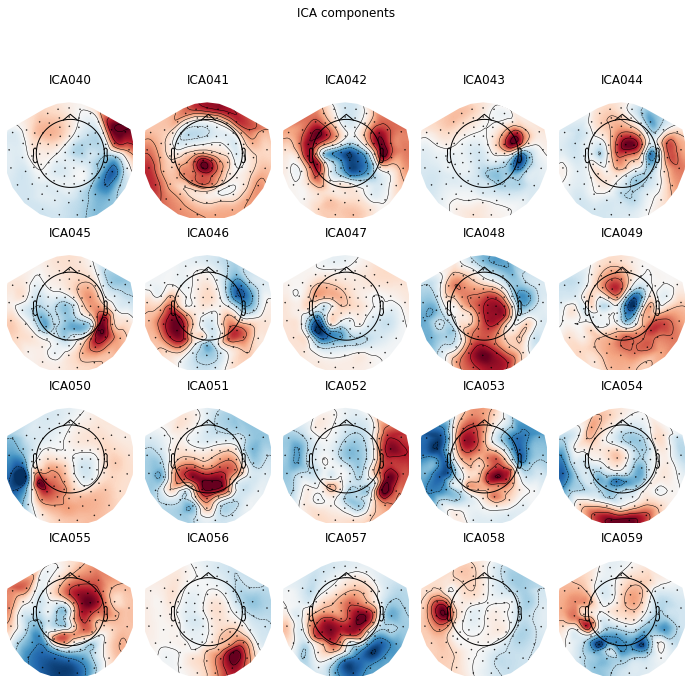

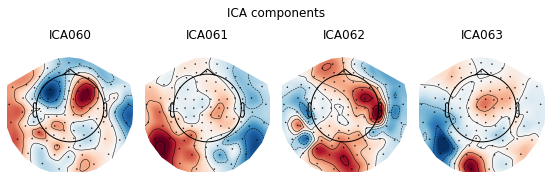

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 561.6x187.56 with 4 Axes>]

In [7]:
ica.plot_components()

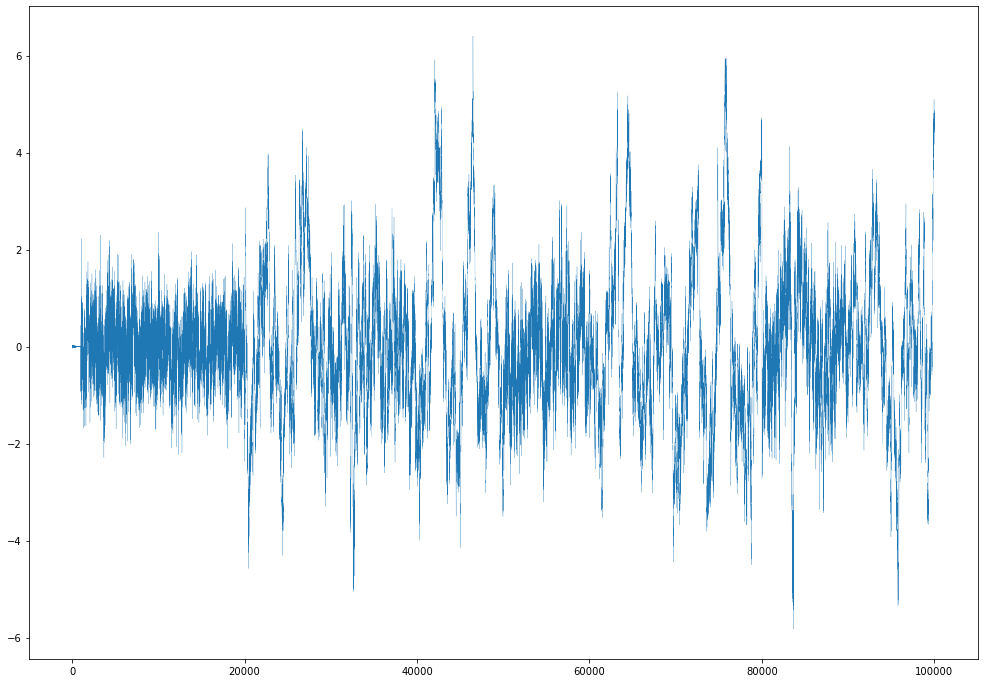

In [24]:
n_comp = 5
plt.plot(ica_sources[n_comp][:100000], linewidth=0.2)

In [28]:
ica.plot_properties(raw, picks=[n_comp])

In [18]:
ica.exclude = [0, 2, 7, 10]

In [19]:
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components


<Raw | MEG2_subj01_sess01_tsss_mc-0.fif, 323 x 5009000 (5009.0 s), ~12.06 GB, data loaded>

## Epoching

In [20]:
reject = dict(grad=4000e-13, mag=4e-12)
events = mne.find_events(raw, min_duration=0.002)
epochs = mne.Epochs(raw,
                    events,
                    event_id=list(range(1, 119)),
                    tmin=-0.1,
                    tmax=1.0,
                    baseline=None,
                    picks='meg')

5236 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 150 200 222 244]
Not setting metadata
Not setting metadata
3480 matching events found
No baseline correction applied
0 projection items activated


In [21]:
epochs.drop_bad()

Loading data for 3480 events and 1101 original time points ...
0 bad epochs dropped


Number of events,3480
Events,1: 3010: 30100: 30101: 30102: 30103: 30104: 30105: 28106: 30107: 30108: 30109: 3011: 29110: 30111: 30112: 29113: 30114: 28115: 29116: 30117: 29118: 3012: 2913: 2914: 3015: 3016: 3017: 2918: 3019: 292: 2920: 2921: 2822: 3023: 2924: 2825: 2926: 3027: 2928: 2929: 303: 2930: 2931: 2932: 2933: 2934: 3035: 2936: 3037: 3038: 3039: 294: 3040: 2941: 2942: 3043: 2944: 3045: 3046: 3047: 3048: 3049: 305: 2950: 2951: 2952: 2853: 2954: 3055: 3056: 3057: 2758: 3059: 306: 3060: 2861: 3062: 2663: 3064: 3065: 2966: 3067: 3068: 2869: 307: 3070: 2971: 3072: 2973: 3074: 3075: 2976: 3077: 3078: 3079: 308: 3080: 3081: 3082: 3083: 3084: 3085: 3086: 3087: 3088: 2989: 299: 2990: 2991: 3092: 2993: 3094: 3095: 2996: 3097: 2998: 3099: 30
Time range,-0.100 – 1.000 sec
Baseline,off


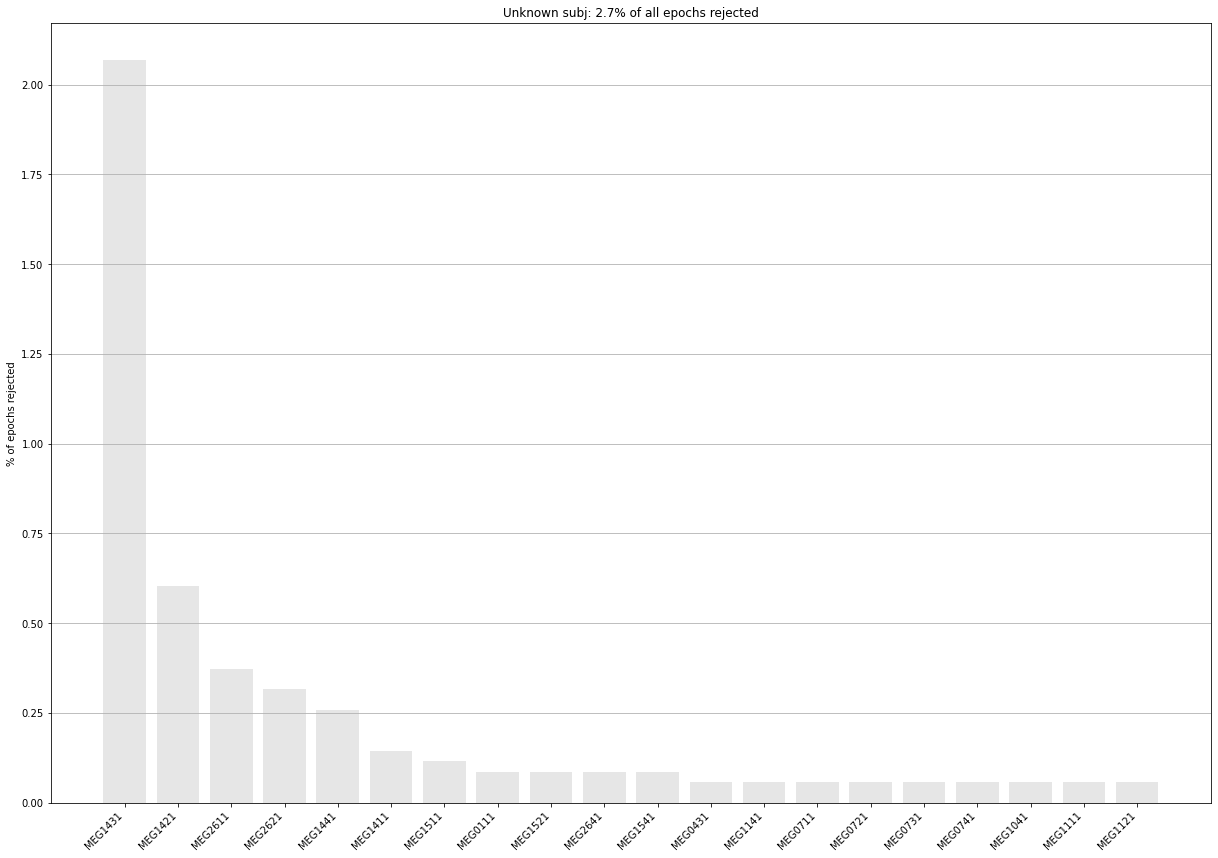

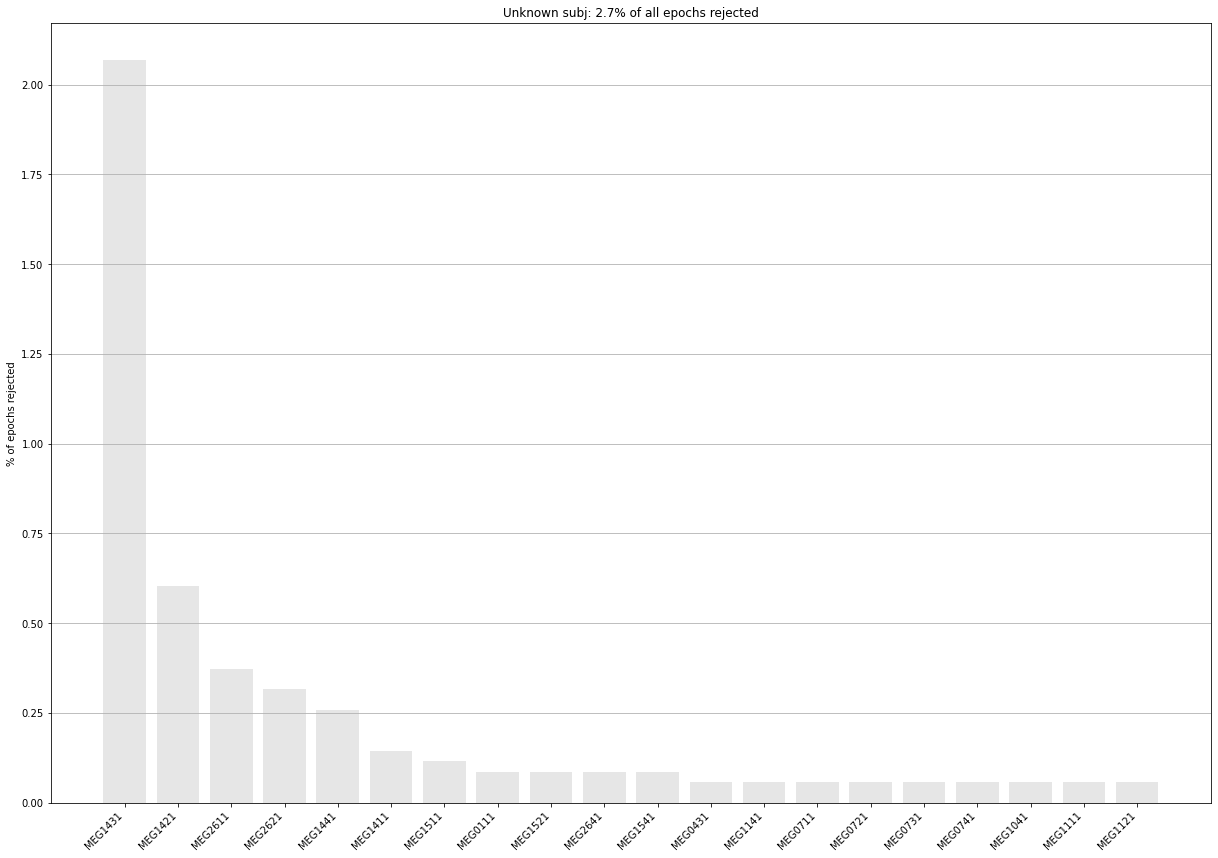

In [63]:
epochs.plot_drop_log()

In [65]:
bad_channel = raw.get_data(picks=['MEG1431'])

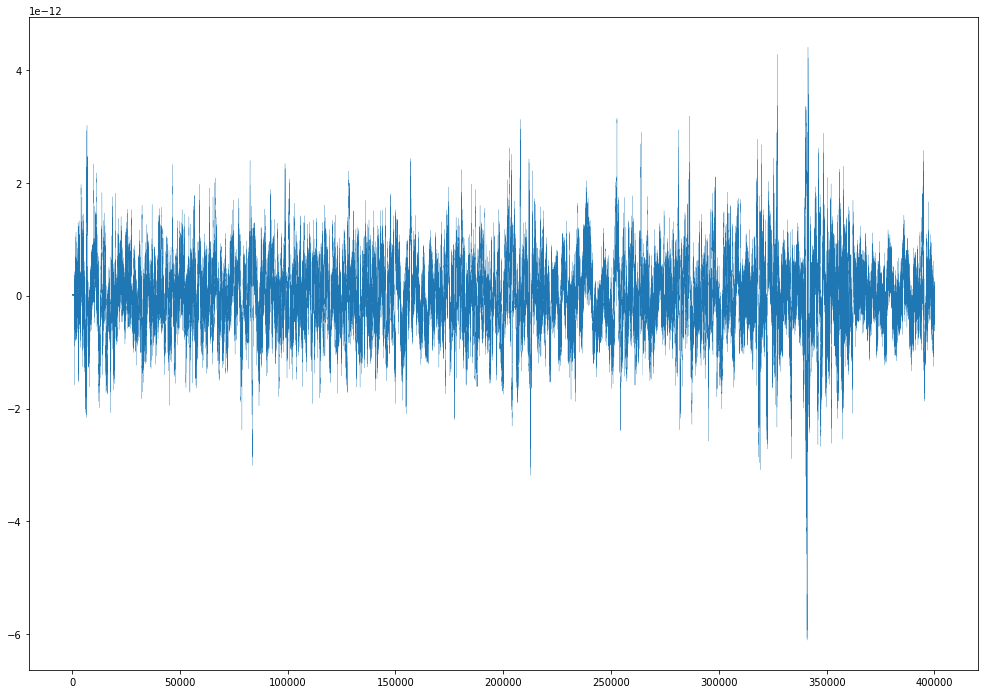

In [75]:
plt.plot(bad_channel[0, :400000], linewidth=0.2)

In [22]:
# Save conditions in individual directories
output_directory = os.path.join('cichy_data', 'subj01', 'raw_data', 'epoched')
for epoch, event in zip(epochs, epochs.events):
    data = epoch.T.astype(np.float32)
    event_id = event[-1]
    os.makedirs(f"{output_directory}/cond{event_id-1}", exist_ok=True)
    n_trials = len(os.listdir(f"{output_directory}/cond{event_id-1}"))
    np.save(f"{output_directory}/cond{event_id-1}/trial{n_trials}.npy", data)

## Event times

In [22]:
event_dict = dict([(str(i), i) for i in range(1, 119)])

events = mne.find_events(raw, min_duration=0.002)
epochs = mne.Epochs(raw,
                    events,
                    event_id=event_dict,
                    tmin=-0.1,
                    tmax=1.0,
                    baseline=None,
                    reject = None,
                    picks='meg')

5310 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 150 200 222 244]
Not setting metadata
Not setting metadata
3540 matching events found
No baseline correction applied
0 projection items activated


In [46]:
ep2 = epochs[-1].get_data()

Loading data for 1 events and 1101 original time points ...
0 bad epochs dropped


In [7]:
for ev in events:
    if ev[2] < 119:
        print(ev)

[162940      0     69]
[163769      0     77]
[164587      0    105]
[165471      0     16]
[166372      0     34]
[168976      0     86]
[169878      0     14]
[170779      0     55]
[171680      0     76]
[172581      0     91]
[175185      0     54]
[176086      0     52]
[176987      0    118]
[177888      0     95]
[180475      0    118]
[181376      0     50]
[182277      0     26]
[184881      0     98]
[185782      0     75]
[186683      0    106]
[189287      0    101]
[190188      0     80]
[191089      0     33]
[191991      0     85]
[192892      0     76]
[195495      0     92]
[196396      0     45]
[197298      0    103]
[199901      0     46]
[200786      0     38]
[201687      0     19]
[202588      0     64]
[203489      0    110]
[206093      0     88]
[206994      0     81]
[207895      0     37]
[208797      0     93]
[211400      0      6]
[212301      0    114]
[213202      0     39]
[215806      0     64]
[216707      0    111]
[217608      0    106]
[220195    

In [35]:
events[-2]

array([5223272,       0,      11])

In [36]:
data = raw.get_data()

In [45]:
data[0, events[-2][0]-48000:events[-2][0]-47000]

array([-1.26995730e-14, -8.65249971e-14,  5.11194869e-14, -4.16983190e-14,
       -9.12912409e-14, -1.12044837e-13, -4.97708001e-14,  1.01720382e-13,
        1.04547254e-13, -1.04925722e-13, -3.81795277e-13, -3.21542683e-13,
       -1.65697198e-13, -2.56273326e-13, -3.23078214e-13, -1.34771172e-13,
       -7.45527432e-14, -2.39135337e-13, -1.79471996e-13, -8.37927863e-14,
        2.12912083e-14, -1.63047455e-13, -2.38547303e-13, -5.13557950e-14,
       -3.89444013e-15, -1.89860358e-13, -3.33822052e-13, -3.96589162e-13,
       -4.05678713e-13, -4.86470364e-13, -5.88373371e-13, -4.78072643e-13,
       -3.36179220e-13, -4.25343161e-13, -4.12959938e-13, -2.68245334e-13,
       -2.62705528e-13, -1.74743048e-13, -4.11557373e-15, -1.96002005e-14,
       -1.11788783e-13, -1.23073267e-13,  9.52866033e-14,  2.00901552e-13,
        6.04307239e-14,  1.35589036e-13,  4.52732505e-13,  5.37098887e-13,
        5.15685028e-13,  4.79080254e-13,  5.39508389e-13,  8.39301032e-13,
        9.25412608e-13,  

In [49]:
ep2[0, 0, 100:]

array([-1.26995730e-14, -8.65249971e-14,  5.11194869e-14, ...,
       -3.46656766e-13, -2.70791455e-13, -3.36258301e-13])

In [52]:
data.shape[1]

5184000